In [3]:
import tweepy
import pandas as pd
import csv
import re
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from wordcloud import WordCloud
import nltk 
from nltk.tokenize.toktok import ToktokTokenizer
tokenizer = ToktokTokenizer()
from nltk.corpus import stopwords
nltk.download("stopwords")

import twitter_credentials as tc

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from simpletransformers.classification import ClassificationModel

import sklearn
from sklearn.model_selection import train_test_split
import random
import torch
from sklearn.model_selection import KFold

import logging
from pathlib import Path

[nltk_data] Downloading package stopwords to /home/uom65/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Tweet Collection and Preprocessing

In [126]:
# Create an authentication object of the AuthHandler class by passing in the credentials
auth = tweepy.OAuthHandler(tc.api_key, tc.api_secret_key)

# Set the access tokens to complete the authentication process
auth.set_access_token(tc.access_token, tc.access_token_secret)

In [127]:
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [128]:
search_words = "(maskup OR maskdown OR mask) AND (coronavirus OR covid OR pandemic OR covid19 OR lockdown OR covid-19)"

# Latitude, logitude and search radius(km) for US
loc = "37.107414,-88.008079,1000km"

# Search dates
date_since = "2022-06-17"
date_until = "2022-06-23"

# We also want to exclude retweets and replies as this may sway results
my_search = search_words + " -filter:retweets" + " -filter:replies" 

In [129]:
# Use the tweepy Cursor method to access tweets from a specified region and between certain dates
tweets = tweepy.Cursor(api.search,
                       q=my_search,
                       lang="en",
                       tweet_mode='extended',
                       geocode=loc,
                       since=date_since,
                       until=date_until).items(1000)

In [130]:
%%time


# Once again, this should take ~2 minutes to run if you are collecting 1000 tweets
tweet_info = [[tweet.id_str,tweet.created_at,tweet.user.location,tweet.full_text] for tweet in tweets]

# Put our data into a dataframe 
df_new = pd.DataFrame(data=tweet_info, columns=['tweet_id_str','date_time','location','tweet_text'])

# Have a quick look at the dataframe
df_new

CPU times: user 1.03 s, sys: 44.4 ms, total: 1.07 s
Wall time: 51.9 s


,tweet_id_str,date_time,location,tweet_text
0,1539759760207216640,2022-06-22 23:58:28,"Dallas, TX, USA",Agreed - so see our work on tweets related to ...
1,1539759415473086464,2022-06-22 23:57:06,"Fayetteville, NC, USA",Airlines that dropped mask requirements are no...
2,1539757863752589313,2022-06-22 23:50:56,"Mishawaka, Indiana USA","Medical Face Mask Dispenser. Used in schools, ..."
3,1539757138767216640,2022-06-22 23:48:03,"Bethesda, MD",Must read. COVID is not the flu. Avoid reinfec...
4,1539755992774221825,2022-06-22 23:43:30,USA,"Now that I’ve had Covid-19 and recovered, do I..."
...,...,...,...,...
995,1537725370312577024,2022-06-17 09:14:32,Switzerland,COVID: the last variant was quite aggressive i...
996,1537712802164449280,2022-06-17 08:24:36,"Jamestown, IN",Looking at Dicknose Teen Wolf Movie Quote Clot...
997,1537712793276715008,2022-06-17 08:24:33,"Jamestown, IN",Mr Oogie Boogie Man Burlap Sack Nightmare Befo...
998,1537693855176335360,2022-06-17 07:09:18,Scotland,So my BF who is 3x vaxxed &amp; wears a mask h...


In [131]:
for i,tweet in enumerate(df_new['tweet_text'].head(20)):
    print(i+1, tweet, '\n')

1 Agreed - so see our work on tweets related to social distancing and mask wearing.  #socialdistancing #maskup #covid @twitter https://t.co/QcA4RqOq4c https://t.co/x7iEdHD24X 

2 Airlines that dropped mask requirements are now suffering staff shortages due to COVID-19 - CBS News https://t.co/6rataCQbOs 

3 Medical Face Mask Dispenser. Used in schools, offices, factories, restaurants, medical offices, salons, gyms, ice rinks or home usage.
SHOP ▶ https://t.co/WA49DzlXw3

#facemask #facemasks #Covid #COVID19 #OmicronVariant #Omicron #OmicronIsAirborne #OmicronVirus #DeltaVariant https://t.co/Cl3MOgFOqv 

4 Must read. COVID is not the flu. Avoid reinfection. Get boosted. Wear a mask. Improve ventilation and filtration. https://t.co/7ek3d6k2Kx 

5 Now that I’ve had Covid-19 and recovered, do I still need to wear a mask ever? Anywhere? 

6 Airlines that dropped mask requirements are now suffering staff shortages due to COVID-19

https://t.co/wSO2cUflTT 

7 Don’t listen to Dems tell you to h

In [132]:
def clean_text(text):
    
    """
    A function to clean the tweet text
    """
    #Remove hyper links
    text = re.sub(r'https?:\/\/\S+', ' ', text)
    
    #Remove @mentions
    text = re.sub(r'@[A-Za-z0-9]+', ' ', text)
    
    #Remove anything that isn't a letter, number, or one of the punctuation marks listed
    text = re.sub(r"[^A-Za-z0-9#'?!,.]+", ' ', text)   
    
    return text

In [133]:
df_new['tweet_text']=df_new['tweet_text'].apply(clean_text)

In [134]:
for i,tweet in enumerate(df_new['tweet_text'].head(20)):
    print(i+1, tweet, '\n')

1 Agreed so see our work on tweets related to social distancing and mask wearing. #socialdistancing #maskup #covid  

2 Airlines that dropped mask requirements are now suffering staff shortages due to COVID 19 CBS News  

3 Medical Face Mask Dispenser. Used in schools, offices, factories, restaurants, medical offices, salons, gyms, ice rinks or home usage. SHOP #facemask #facemasks #Covid #COVID19 #OmicronVariant #Omicron #OmicronIsAirborne #OmicronVirus #DeltaVariant  

4 Must read. COVID is not the flu. Avoid reinfection. Get boosted. Wear a mask. Improve ventilation and filtration.  

5 Now that I ve had Covid 19 and recovered, do I still need to wear a mask ever? Anywhere? 

6 Airlines that dropped mask requirements are now suffering staff shortages due to COVID 19  

7 Don t listen to Dems tell you to huddle up and mask inside. The human body has developed the perfect immune system over the eons. Besides, if a fart can pass through denim jeans, Covid can damn sure pass through you

In [135]:
df_new['tweet_text']=df_new['tweet_text'].str.lower()
df_new

,tweet_id_str,date_time,location,tweet_text
0,1539759760207216640,2022-06-22 23:58:28,"Dallas, TX, USA",agreed so see our work on tweets related to so...
1,1539759415473086464,2022-06-22 23:57:06,"Fayetteville, NC, USA",airlines that dropped mask requirements are no...
2,1539757863752589313,2022-06-22 23:50:56,"Mishawaka, Indiana USA","medical face mask dispenser. used in schools, ..."
3,1539757138767216640,2022-06-22 23:48:03,"Bethesda, MD",must read. covid is not the flu. avoid reinfec...
4,1539755992774221825,2022-06-22 23:43:30,USA,"now that i ve had covid 19 and recovered, do i..."
...,...,...,...,...
995,1537725370312577024,2022-06-17 09:14:32,Switzerland,covid the last variant was quite aggressive in...
996,1537712802164449280,2022-06-17 08:24:36,"Jamestown, IN",looking at dicknose teen wolf movie quote clot...
997,1537712793276715008,2022-06-17 08:24:33,"Jamestown, IN",mr oogie boogie man burlap sack nightmare befo...
998,1537693855176335360,2022-06-17 07:09:18,Scotland,so my bf who is 3x vaxxed amp wears a mask has...


<Figure size 1440x720 with 0 Axes>

(-0.5, 499.5, 399.5, -0.5)

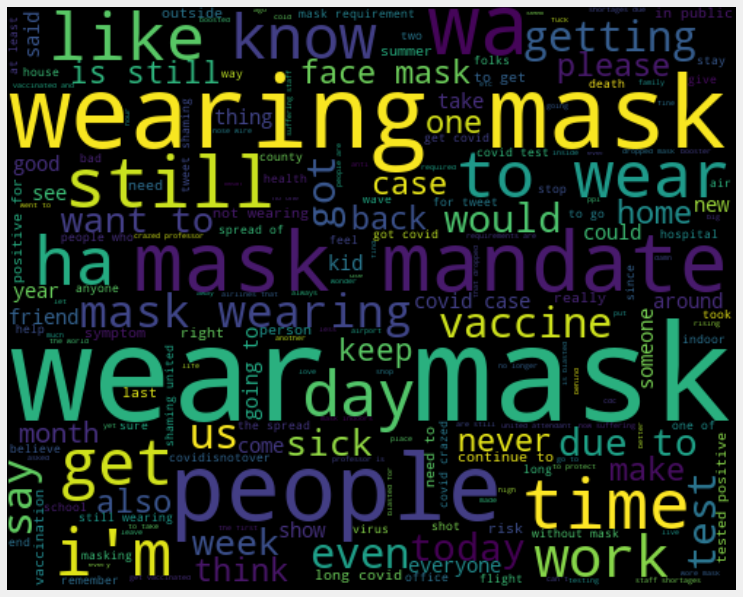

In [136]:
# Plot a word cloud

all_words = ' '.join( [data for data in df_new['tweet_text']])
word_cloud = WordCloud(width=500, height=400, random_state=21, max_font_size = 100,
                       stopwords=stopwords).generate(all_words)

plt.figure(figsize = (20,10))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Sentimental Analysis With Transfer Learning Approach

In [28]:
df2 = pd.read_csv('labelled_data_cleaned.csv')
df2

,tweet_text,label
0,Jesus Ive actually spent all the money I saved...,1
1,Coronavirus and throat cancer looking after yo...,1
2,Me sick at home in Houston w Covid symptoms ri...,1
3,Coronavirus pandemic prompts record drop in gl...,1
4,Coronavirus How can we make postpandemic citie...,1
...,...,...
4224,Was recently tested for #coronavirus not at al...,1
4225,"Despite the Lockdown, Crises, Vera Lynn We'll ...",1
4226,"Due to COVID and mandatory face masks, million...",0
4227,Something someone said to me in regards to me ...,0


In [29]:
bi_df = df2[(df2.label==0) | (df2.label==2) ] # make it binary classification
bi_df.label.replace(2,1, inplace=True) # make it binary classification

pos_samples = bi_df[bi_df['label']==1]
neg_samples = bi_df[bi_df['label']==0].sample(len(pos_samples), random_state=42)

bal_bi_df = pd.concat([pos_samples, neg_samples])

bi_df['label'].value_counts()
bal_bi_df['label'].value_counts()

/opt/workshop/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


0    1527
1     747
Name: label, dtype: int64

1    747
0    747
Name: label, dtype: int64

In [30]:
train_df, val_df = train_test_split(bi_df, test_size=0.2,  random_state=42)

In [31]:
train_df['label'].value_counts()
val_df['label'].value_counts()

0    1213
1     606
Name: label, dtype: int64

0    314
1    141
Name: label, dtype: int64

In [140]:
def change_label(score):
    if score == 0:
        return 'Negative'
    elif score == 1:
        return 'Positive'

## Using COVID-Twitter BERT

In [85]:
train_df, val_df = train_test_split(bi_df, test_size=0.2,  random_state=42)

In [86]:
train_df['label'].value_counts()
val_df['label'].value_counts()

0    1213
1     606
Name: label, dtype: int64

0    314
1    141
Name: label, dtype: int64

In [87]:
# Build the ct-bert model

ct_model = ClassificationModel('bert',
                            'digitalepidemiologylab/covid-twitter-bert',
                            num_labels=2,
                            use_cuda=False,
                            args={'overwrite_output_dir': True})

Some weights of the model checkpoint at digitalepidemiologylab/covid-twitter-bert were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassifi

In [88]:
%%time

# Train the ct-bert model

ct_model.train_model(train_df=train_df, eval_df=val_df)

/opt/workshop/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:277: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


/opt/workshop/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


/opt/workshop/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)



CPU times: user 3h 4min 7s, sys: 1min 37s, total: 3h 5min 45s
Wall time: 12min 45s


In [89]:
%%time

# Calculated and print out the f1 score

result, model_outputs, wrong_predictions = ct_model.eval_model(val_df, f1=multi_F1);
print('f1 score = ',result['f1'])

/opt/workshop/lib/python3.8/site-packages/simpletransformers/classification/classification_model.py:750: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(



f1 score =  0.8630787037037038
CPU times: user 12min 19s, sys: 1.97 s, total: 12min 21s
Wall time: 49.2 s


In [90]:
%%time

# Calculated and print out the results in the classification report

result, model_outputs, wrong_predictions = ct_model.eval_model(val_df, report=multi_classification_report);
print('Classification Report: ', result['report'])


Classification Report:                precision    recall  f1-score   support

           0       0.90      0.94      0.92       314
           1       0.84      0.77      0.81       141

    accuracy                           0.89       455
   macro avg       0.87      0.85      0.86       455
weighted avg       0.88      0.89      0.88       455

CPU times: user 12min 14s, sys: 1.79 s, total: 12min 16s
Wall time: 49.1 s


In [141]:
# The text from your new tweets

new_tweets_ctb = df_new['tweet_text'].iloc[0:1000].values

In [142]:
new_tweets_ctb_transpose = new_tweets_ctb.transpose()

In [143]:
# Obtain the model's sentiment predictions for your collected tweets

new_result_ctb = bert_model.predict(new_tweets_ctb_transpose)
print(new_result_ctb[0])


[1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0
 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0
 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0
 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1 0 0 0 0
 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0
 0 0 0 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 1 1
 1 1 1 0 0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0
 0 1 0 0 1 1 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 1 1 0 0 0 0

In [197]:
predicted_ctb_df = pd.DataFrame(new_result_ctb[0], columns=['predicted_labels_ctb'])

In [198]:
new_predicted_ctb_df  = pd.concat([df_new, predicted_ctb_df], axis=1)

In [199]:
new_predicted_ctb_df

,tweet_id_str,date_time,location,tweet_text,predicted_labels_ctb
0,1539759760207216640,2022-06-22 23:58:28,"Dallas, TX, USA",agreed so see our work on tweets related to so...,1
1,1539759415473086464,2022-06-22 23:57:06,"Fayetteville, NC, USA",airlines that dropped mask requirements are no...,0
2,1539757863752589313,2022-06-22 23:50:56,"Mishawaka, Indiana USA","medical face mask dispenser. used in schools, ...",1
3,1539757138767216640,2022-06-22 23:48:03,"Bethesda, MD",must read. covid is not the flu. avoid reinfec...,1
4,1539755992774221825,2022-06-22 23:43:30,USA,"now that i ve had covid 19 and recovered, do i...",0
...,...,...,...,...,...
995,1537725370312577024,2022-06-17 09:14:32,Switzerland,covid the last variant was quite aggressive in...,0
996,1537712802164449280,2022-06-17 08:24:36,"Jamestown, IN",looking at dicknose teen wolf movie quote clot...,1
997,1537712793276715008,2022-06-17 08:24:33,"Jamestown, IN",mr oogie boogie man burlap sack nightmare befo...,1
998,1537693855176335360,2022-06-17 07:09:18,Scotland,so my bf who is 3x vaxxed amp wears a mask has...,0


In [200]:
new_predicted_ctb_df['predicted_sentiments_ctb'] = new_predicted_ctb_df['predicted_labels_ctb'].apply(change_label)

In [201]:
new_predicted_ctb_df

,tweet_id_str,date_time,location,tweet_text,predicted_labels_ctb,predicted_sentiments_ctb
0,1539759760207216640,2022-06-22 23:58:28,"Dallas, TX, USA",agreed so see our work on tweets related to so...,1,Positive
1,1539759415473086464,2022-06-22 23:57:06,"Fayetteville, NC, USA",airlines that dropped mask requirements are no...,0,Negative
2,1539757863752589313,2022-06-22 23:50:56,"Mishawaka, Indiana USA","medical face mask dispenser. used in schools, ...",1,Positive
3,1539757138767216640,2022-06-22 23:48:03,"Bethesda, MD",must read. covid is not the flu. avoid reinfec...,1,Positive
4,1539755992774221825,2022-06-22 23:43:30,USA,"now that i ve had covid 19 and recovered, do i...",0,Negative
...,...,...,...,...,...,...
995,1537725370312577024,2022-06-17 09:14:32,Switzerland,covid the last variant was quite aggressive in...,0,Negative
996,1537712802164449280,2022-06-17 08:24:36,"Jamestown, IN",looking at dicknose teen wolf movie quote clot...,1,Positive
997,1537712793276715008,2022-06-17 08:24:33,"Jamestown, IN",mr oogie boogie man burlap sack nightmare befo...,1,Positive
998,1537693855176335360,2022-06-17 07:09:18,Scotland,so my bf who is 3x vaxxed amp wears a mask has...,0,Negative


In [202]:
new_predicted_ctb_df['predicted_sentiments_ctb'].value_counts()

Negative    763
Positive    237
Name: predicted_sentiments_ctb, dtype: int64

In [203]:
new_predicted_ctb_df['date'] = pd.to_datetime(new_predicted_ctb_df['date_time']).dt.date

In [204]:
new_predicted_ctb_df

,tweet_id_str,date_time,location,tweet_text,predicted_labels_ctb,predicted_sentiments_ctb,date
0,1539759760207216640,2022-06-22 23:58:28,"Dallas, TX, USA",agreed so see our work on tweets related to so...,1,Positive,2022-06-22
1,1539759415473086464,2022-06-22 23:57:06,"Fayetteville, NC, USA",airlines that dropped mask requirements are no...,0,Negative,2022-06-22
2,1539757863752589313,2022-06-22 23:50:56,"Mishawaka, Indiana USA","medical face mask dispenser. used in schools, ...",1,Positive,2022-06-22
3,1539757138767216640,2022-06-22 23:48:03,"Bethesda, MD",must read. covid is not the flu. avoid reinfec...,1,Positive,2022-06-22
4,1539755992774221825,2022-06-22 23:43:30,USA,"now that i ve had covid 19 and recovered, do i...",0,Negative,2022-06-22
...,...,...,...,...,...,...,...
995,1537725370312577024,2022-06-17 09:14:32,Switzerland,covid the last variant was quite aggressive in...,0,Negative,2022-06-17
996,1537712802164449280,2022-06-17 08:24:36,"Jamestown, IN",looking at dicknose teen wolf movie quote clot...,1,Positive,2022-06-17
997,1537712793276715008,2022-06-17 08:24:33,"Jamestown, IN",mr oogie boogie man burlap sack nightmare befo...,1,Positive,2022-06-17
998,1537693855176335360,2022-06-17 07:09:18,Scotland,so my bf who is 3x vaxxed amp wears a mask has...,0,Negative,2022-06-17


In [205]:
new_predicted_ctb_df['predicted_sentiments_ctb'].value_counts()

Negative    763
Positive    237
Name: predicted_sentiments_ctb, dtype: int64

([<matplotlib.patches.Wedge at 0x7faab9b533a0>,
 [Text(-0.7454110900026251, 0.8089266387634285, 'Positive'),
  Text(0.7454111278712131, -0.8089266038682162, 'Negative')],
 [Text(-0.40658786727415913, 0.4412327120527792, '23.7%'),
  Text(0.40658788792975253, -0.441232693019027, '76.3%')])

(-1.1053028926209563,
 1.105098081278399,
 -1.1041481387426697,
 1.1001975402310005)

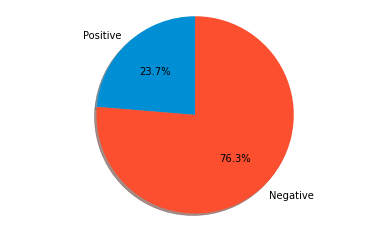

In [206]:
import matplotlib.pyplot as plt

labels = 'Positive', 'Negative'
sizes = [237, 763]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.show()

In [207]:
%matplotlib inline

In [222]:
table1 = new_predicted_ctb_df['date'].value_counts().rename_axis('dates').to_frame('number of tweets')
table1

,number of tweets
dates,
2022-06-21,219
2022-06-22,209
2022-06-20,179
2022-06-19,144
2022-06-17,141
2022-06-18,108


Text(0.5, 0, 'Dates')

Text(0, 0.5, 'NUmber of tweets')

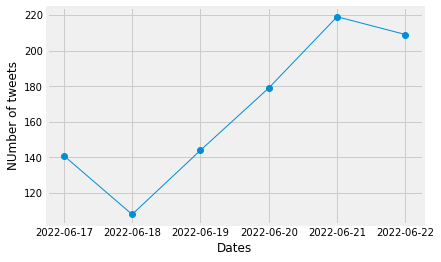

In [230]:
x = ['2022-06-17', '2022-06-18', '2022-06-19','2022-06-20','2022-06-21','2022-06-22'] 
y = [141,108,144,179,219,209]
plt.xlabel('Dates')
plt.ylabel('NUmber of tweets')

plt.plot(x,y,marker='o',linewidth=1)
plt.show()

In [233]:
table2 = new_predicted_ctb_df.groupby('date')['predicted_sentiments_ctb'].value_counts()

In [234]:
table2

date        predicted_sentiments_ctb
2022-06-17  Negative                    100
            Positive                     41
2022-06-18  Negative                     81
            Positive                     27
2022-06-19  Negative                    121
            Positive                     23
2022-06-20  Negative                    140
            Positive                     39
2022-06-21  Negative                    163
            Positive                     56
2022-06-22  Negative                    158
            Positive                     51
Name: predicted_sentiments_ctb, dtype: int64

Text(0.5, 0, 'Dates')

Text(0, 0.5, 'NUmber of tweets')

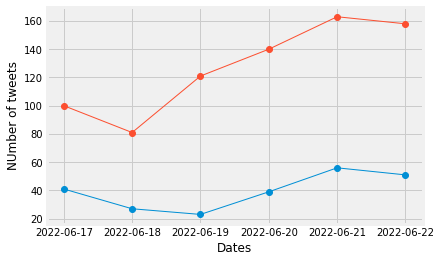

In [235]:
x = ['2022-06-17', '2022-06-18', '2022-06-19','2022-06-20','2022-06-21','2022-06-22'] 
positivey = [41,27,23,39,56,51]
negativey = [100,81,121,140,163,158]

plt.xlabel('Dates')
plt.ylabel('NUmber of tweets')

plt.plot(x,positivey,marker='o',linewidth=1)
plt.plot(x,negativey,marker='o',linewidth=1)

plt.show()